# Time Ordered Exponential and Floquet Expansion
This notebook computes time-ordred exponential of a time-dependent Hamiltonain for a 2-level system. The purpose is to construct this propagator using Trotter formula and then verify it by substitution back into the Schrodinger equation. Then expand the same using Floquet theorem to get a series of time-independent Hamiltonians and verify the equivalence with the Trotter scheme.<br>

The Hamiltonian is:

$$
 H(t) = \frac{1}{2} E_0 Z + \frac{1}{2} V_0 sin(\omega t)X
$$

We do instantaenous exponentiation for a small interval $[t,t+\delta t]$ over which we hold $H(t)$ constant at its initial value in the interval,

$$
U_{\delta t}(t)\equiv\exp{\left[-i \frac{\delta t}{\hbar} H(t)\right]} = I \cos(\Omega(t)\delta t) - i \frac{E_0 Z + V_0 \sin(\omega t) X}{2 \Omega(t)} \sin(\Omega(t)\delta t),
$$

where we have defined,

$$
\Omega(t) = \frac{1}{2\hbar}\sqrt{E_0^2 + V_0^2 \sin^2(\omega t)}
$$

Under the Trotter formula, we write

$$
\mathcal{T} \exp{\left[\frac{-i}{\hbar}\int_{t_0}^{t} H(t')dt'\right]} = U_{\delta t}(t-\delta t)\cdots U_{\delta t}(t_0+2\delta t)U_{\delta t}(t_0+\delta t)U_{\delta t}(t_0)
$$

In [304]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import signal
from math import pi
from matplotlib import pyplot as plt
from algolab.utils import plotting as PLT
%matplotlib inline

In [264]:
# Time is measured in 1/energy so hbar=1
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1, 0]])

def Hamiltonian(t, E0, V0, omega):    
    H = E0/2 * Z + V0 / 2 * np.sin(omega*t) * X
    return H

def Omega(t, E0, V0, omega):
    return 1/2 * np.sqrt( E0**2 + V0**2 * np.sin(omega*t)**2 )

def dpsidt(t , psi, E0, V0, omega):
    H = Hamiltonian(t,E0, V0, omega)
    dy = -1j * (H @ psi)
    return dy

def UnitaryStep(dt, t, E0, V0, omega):
    W = Omega(t,E0,V0,omega)
    H = Hamiltonian(t,E0,V0,omega)
    U = np.cos(W*dt)*np.eye(2) - 1j* np.sin(W*dt)/ W * H
    return U
    
def PropagatorTrotter(dt, tmax, E0, V0, omega, steps = False):
    t = np.arange(0, tmax, dt)
    U = np.eye(2)
    Usteps = [U]
    for i in range(1,len(t)):
        U1 = UnitaryStep(t[i]-t[i-1], t[i-1], E0, V0, omega)
        U = U1 @ U
        if steps:
            Usteps += [U1]
    if steps:
        return Usteps, t
    return U

def solve_ivp_trotter(dt, tmax, E0,V0,omega):
    Usteps,t = propagator_trotter(dt, tmax, E0, V0, omega, steps=True)
    psi0 = np.array([0,1],dtype=complex)
    psi = [psi0]
    for i in range(1, len(t)):
        psi += [ Usteps[i] @ psi[i-1] ]
    psi = np.array(psi)
    return psi, t

def EvalResidual(t, psi, E0, V0, omega):
    dydt = np.array([np.gradient(psi[:,i],dt) for i in range(2)]).T
    rhs = np.array([-1j*Hamiltonian(t[i],E0, V0, omega) @ psi[i] for i in range(len(t))])
    res = (np.abs(dydt-rhs)**2).sum(axis=1)
    return res

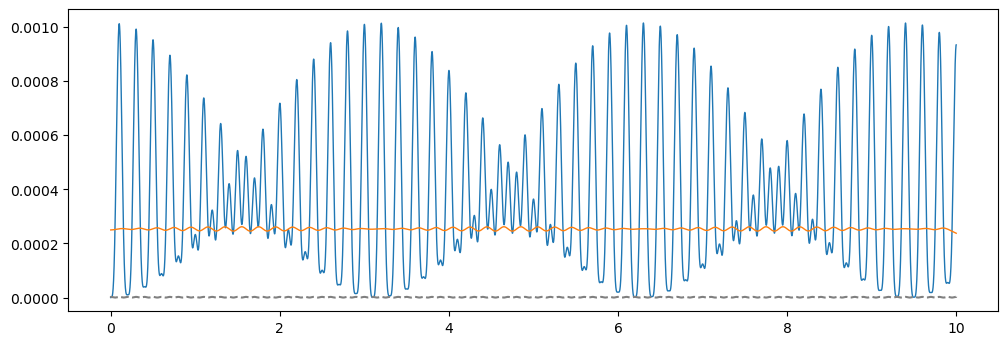

In [328]:
fig,ax=PLT.subplots(ncols=1,figsize=(12,4))
T = 0.2
params = 1, 1, 2*pi/T
Wmax = Omega(T/4, *params)
dt = min(T/1000, 2*np.pi/Wmax/4000)
for dt in [dt]:
    psi, t = solve_ivp_trotter(dt, max(3*T,10), *params)
    phi = np.array([signal.savgol_filter(psi[:,i].real, int(T/dt-1), 1) + 1j*signal.savgol_filter(psi[:,i].imag, int(T/dt-1), 1) for i in [0,1]]).T
    f = np.abs(psi)**2
    g = np.abs(phi)**2
    chk = np.sum(np.abs(psi)**2,axis=1)
    residual = EvalResidual(t, psi, *params)
    W = Omega(t, *params)
    ax.plot(t, f[:,0], linewidth=1)
    ax.plot(t, g[:,0], linewidth=1)
    ax.plot(t, residual, '--',color='gray')

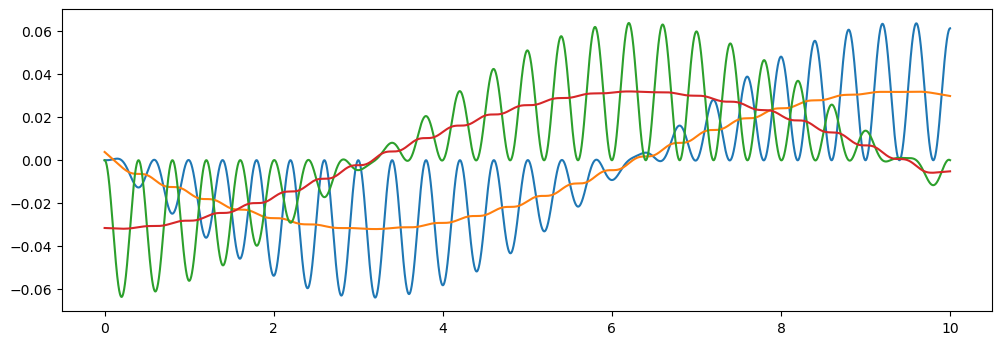

In [322]:
fig,ax=PLT.subplots(ncols=1,figsize=(12,4))
ax.plot(t, psi[:,0].real)
ax.plot(t, g[:,0].real)
ax.plot(t, psi[:,0].imag)
ax.plot(t, g[:,0].imag)